In [34]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Question 2: Classification Using CNN

### Data Loading and Preprocessing

In [36]:
def load_mnist_data(path):
    splits = ['train', 'val', 'test']
    data = {'train': [], 'val': [], 'test': []}
    labels = {'train': [], 'val': [], 'test': []}
    for split in splits:
        split_path = os.path.join(path, split)
        for label in os.listdir(split_path):
            label_path = os.path.join(split_path, label)
            if (len(label)==1 and int(label) == 0):
                cur_label = 0
            else:
                cur_label = len(label)
            if os.path.isdir(label_path):
                for image_name in os.listdir(label_path):
                    image_path = os.path.join(label_path, image_name)
                    try:
                        image = Image.open(image_path).convert('L')
                        image_array = np.array(image)
                        data[split].append(image_array)
                        labels[split].append(cur_label)
                    except Exception as e:
                        print(f"Error loading image {image_name}: {e}")
    
    return data['train'], labels['train'], data['val'], labels['val'], data['test'], labels['test']



In [37]:
data_path = "./../../data/external/double_mnist"

train_data, train_labels, val_data, val_labels, test_data, test_labels = load_mnist_data(data_path)

In [38]:
class MultiMNISTDataset(Dataset):
    def __init__(self, images, labels, task = 'classification', transform=None):
        self.images = images
        self.labels = labels
        self.task = task
        self.transform = transform
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = torch.tensor(image, dtype=torch.float32) / 255.0
        image = image.unsqueeze(0)

        if self.transform:
            image = self.transform(image)
            
        if (self.task == 'classification'):
            label = torch.tensor(label, dtype=torch.long).to(device)
        elif (self.task == 'regression'):
            label = torch.tensor(label, dtype=torch.float32).to(device).unsqueeze(0)
        return image, label


### Implement the CNN Class

In [39]:
class CNN(nn.Module):
    def __init__(self, task='classification', num_classes=10):
        super(CNN, self).__init__()
        
        self.task = task
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
        self.fc1 = None
        self.fc2 = nn.Linear(128, 64)
        
        if task == 'classification':
            self.fc3 = nn.Linear(64, num_classes)
        elif task == 'regression':
            self.fc3 = nn.Linear(64, 1)

    def _initialize_fc(self, input_shape, device):
        dummy_input = torch.zeros(1, *input_shape).to(device)
        with torch.no_grad():
            output, _ = self._forward_conv(dummy_input)
        flattened_size = output.view(-1).shape[0]
        self.fc1 = nn.Linear(flattened_size, 128).to(device)

    def _forward_conv(self, x):
        feature_maps = {}
        x = self.pool(self.relu(self.conv1(x)))
        feature_maps['conv1'] = x
        x = self.pool(self.relu(self.conv2(x)))
        feature_maps['conv2'] = x
        x = self.pool(self.relu(self.conv3(x)))
        feature_maps['conv3'] = x
        return x, feature_maps

    def forward(self, x):
        if self.fc1 is None:
            self._initialize_fc(x.shape[1:], x.device)

        x, feature_maps = self._forward_conv(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x, feature_maps

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            y_pred, feature_maps = self.forward(x)
        return y_pred, feature_maps

    def get_accuracy(self, y_pred, y_true):
        if self.task == 'classification':
            y_pred = torch.argmax(y_pred, dim=1)
            return (y_pred == y_true).float().mean()
        elif self.task == 'regression':
            y_pred = torch.round(y_pred)
            return (y_pred == y_true).float().mean()

    def loss(self, y_pred, y_true):
        if self.task == 'classification':
            return F.cross_entropy(y_pred, y_true)
        elif self.task == 'regression':
            return F.mse_loss(y_pred, y_true)

    def train_model(self, optimizer, train_loader, val_loader, num_epochs=10, device='cpu'):
        self.to(device)
        for epoch in range(num_epochs):
            self.train()
            train_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}")
            
            for i, (x, y) in train_progress:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                y_pred, _ = self.forward(x)
                loss = self.loss(y_pred, y)
                loss.backward()
                optimizer.step()
                train_progress.set_postfix({"Loss": f"{loss.item():.4f}"})
            
            self.eval()
            total_accuracy = 0
            total_loss = 0
            with torch.no_grad():
                for x, y in val_loader:
                    x, y = x.to(device), y.to(device)
                    y_pred, _ = self.forward(x)
                    total_loss += self.loss(y_pred, y).item()
                    total_accuracy += self.get_accuracy(y_pred, y).item()
                    
                avg_loss = total_loss / len(val_loader)
                accuracy = total_accuracy / len(val_loader)
                print(f"Epoch {epoch + 1}, Validation Accuracy: {accuracy*100:.2f}%, Validation Loss: {avg_loss:.6f}")

    def visulize_feature_maps(self, train_loader, device='cpu'):
        self.eval()
        with torch.no_grad():
            fig, ax = plt.subplots(3, 3, figsize=(15, 5))
            cnt = 0
            for x, y in train_loader:
                x = x.to(device)
                if cnt == 3:
                    break
                _, feature_maps = self.forward(x)
                for i in range(3):
                    ax[cnt, i].imshow(feature_maps[f'conv{i+1}'][0, 0].cpu().numpy(), cmap='gray')
                    ax[cnt, i].set_title(f'Conv{i+1} Feature Map')
                    ax[cnt, i].axis('off')
                cnt += 1

            plt.show()

In [40]:
train_data_classification = MultiMNISTDataset(train_data, train_labels)
val_data_classification = MultiMNISTDataset(val_data, val_labels)
test_data_classification = MultiMNISTDataset(test_data, test_labels)

train_loader_classification = DataLoader(train_data_classification, batch_size=32, shuffle=True)
val_loader_classification = DataLoader(val_data_classification, batch_size=32, shuffle=False)
test_loader_classification = DataLoader(test_data_classification, batch_size=32, shuffle=False)

In [41]:
model_single_classification = CNN(task='classification', num_classes=4).to(device)
optimizer = torch.optim.Adam(model_single_classification.parameters(), lr=0.001)
model_single_classification.train_model(optimizer, train_loader_classification, val_loader_classification, num_epochs=20, device=device)

Epoch 1/20: 100%|██████████| 394/394 [00:07<00:00, 55.82it/s, Loss=0.0154]


Epoch 1, Validation Accuracy: 98.47%, Validation Loss: 0.045583


Epoch 2/20: 100%|██████████| 394/394 [00:05<00:00, 74.52it/s, Loss=0.0056]


Epoch 2, Validation Accuracy: 99.53%, Validation Loss: 0.014361


Epoch 3/20: 100%|██████████| 394/394 [00:05<00:00, 73.09it/s, Loss=0.0063]


Epoch 3, Validation Accuracy: 99.80%, Validation Loss: 0.008246


Epoch 4/20: 100%|██████████| 394/394 [00:06<00:00, 64.38it/s, Loss=0.0007]


Epoch 4, Validation Accuracy: 99.67%, Validation Loss: 0.008610


Epoch 5/20: 100%|██████████| 394/394 [00:08<00:00, 45.44it/s, Loss=0.0002]


Epoch 5, Validation Accuracy: 99.73%, Validation Loss: 0.009455


Epoch 6/20: 100%|██████████| 394/394 [00:05<00:00, 77.16it/s, Loss=0.0000]


Epoch 6, Validation Accuracy: 99.80%, Validation Loss: 0.007327


Epoch 7/20: 100%|██████████| 394/394 [00:06<00:00, 62.09it/s, Loss=0.0000]


Epoch 7, Validation Accuracy: 99.80%, Validation Loss: 0.005274


Epoch 8/20: 100%|██████████| 394/394 [00:05<00:00, 72.36it/s, Loss=0.0000]


Epoch 8, Validation Accuracy: 99.97%, Validation Loss: 0.001591


Epoch 9/20: 100%|██████████| 394/394 [00:05<00:00, 77.07it/s, Loss=0.0000]


Epoch 9, Validation Accuracy: 99.73%, Validation Loss: 0.007784


Epoch 10/20: 100%|██████████| 394/394 [00:04<00:00, 86.30it/s, Loss=0.0001]


Epoch 10, Validation Accuracy: 99.09%, Validation Loss: 0.025345


Epoch 11/20: 100%|██████████| 394/394 [00:04<00:00, 86.32it/s, Loss=0.0000]


Epoch 11, Validation Accuracy: 99.90%, Validation Loss: 0.004040


Epoch 12/20: 100%|██████████| 394/394 [00:04<00:00, 86.63it/s, Loss=0.0000]


Epoch 12, Validation Accuracy: 99.80%, Validation Loss: 0.003820


Epoch 13/20: 100%|██████████| 394/394 [00:04<00:00, 84.58it/s, Loss=0.0004]


Epoch 13, Validation Accuracy: 99.87%, Validation Loss: 0.002908


Epoch 14/20: 100%|██████████| 394/394 [00:04<00:00, 85.68it/s, Loss=0.0000]


Epoch 14, Validation Accuracy: 99.97%, Validation Loss: 0.001185


Epoch 15/20: 100%|██████████| 394/394 [00:04<00:00, 84.30it/s, Loss=0.0000]


Epoch 15, Validation Accuracy: 100.00%, Validation Loss: 0.000545


Epoch 16/20: 100%|██████████| 394/394 [00:05<00:00, 78.49it/s, Loss=0.0000]


Epoch 16, Validation Accuracy: 100.00%, Validation Loss: 0.000486


Epoch 17/20: 100%|██████████| 394/394 [00:04<00:00, 82.09it/s, Loss=0.0000]


Epoch 17, Validation Accuracy: 100.00%, Validation Loss: 0.000443


Epoch 18/20: 100%|██████████| 394/394 [00:04<00:00, 84.36it/s, Loss=0.0000]


Epoch 18, Validation Accuracy: 100.00%, Validation Loss: 0.000429


Epoch 19/20: 100%|██████████| 394/394 [00:04<00:00, 85.95it/s, Loss=0.0000]


Epoch 19, Validation Accuracy: 100.00%, Validation Loss: 0.000410


Epoch 20/20: 100%|██████████| 394/394 [00:04<00:00, 85.41it/s, Loss=0.0000]


Epoch 20, Validation Accuracy: 100.00%, Validation Loss: 0.000399


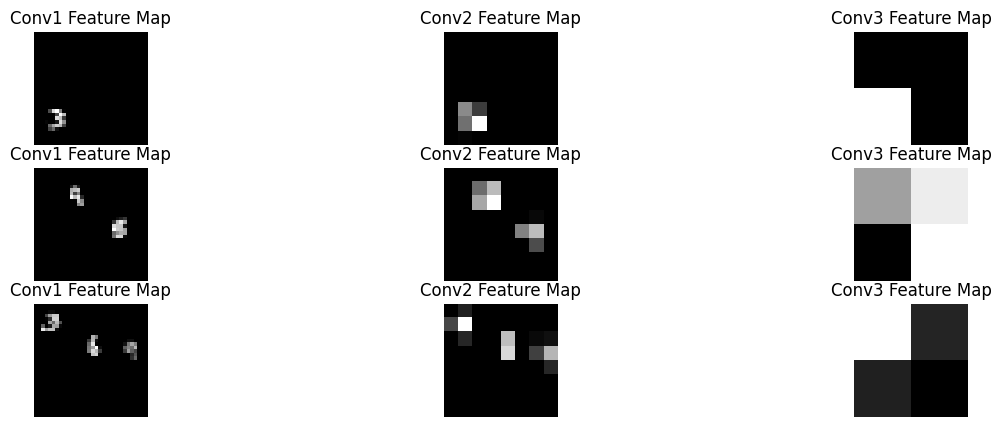

In [42]:
model_single_classification.visulize_feature_maps(train_loader_classification, device=device)

In [43]:
train_data_regression = MultiMNISTDataset(train_data, train_labels, task='regression')
val_data_regression = MultiMNISTDataset(val_data, val_labels, task='regression')
test_data_regression = MultiMNISTDataset(test_data, test_labels, task='regression')

train_loader_regression = DataLoader(train_data_regression, batch_size=32, shuffle=True)
val_loader_regression = DataLoader(val_data_regression, batch_size=32, shuffle=False)
test_loader_regression = DataLoader(test_data_regression, batch_size=32, shuffle=False)

In [44]:
model_single_regression = CNN(task='regression').to(device)
optimizer = torch.optim.Adam(model_single_regression.parameters(), lr=0.001)
model_single_regression.train_model(optimizer, train_loader_regression, val_loader_regression, num_epochs=15, device=device)

Epoch 1/15: 100%|██████████| 394/394 [00:05<00:00, 77.92it/s, Loss=0.0512]


Epoch 1, Validation Accuracy: 94.71%, Validation Loss: 0.063119


Epoch 2/15: 100%|██████████| 394/394 [00:04<00:00, 80.25it/s, Loss=0.0188]


Epoch 2, Validation Accuracy: 98.74%, Validation Loss: 0.033658


Epoch 3/15: 100%|██████████| 394/394 [00:04<00:00, 83.44it/s, Loss=0.0127]


Epoch 3, Validation Accuracy: 99.04%, Validation Loss: 0.028194


Epoch 4/15: 100%|██████████| 394/394 [00:04<00:00, 83.14it/s, Loss=0.0156]


Epoch 4, Validation Accuracy: 99.60%, Validation Loss: 0.021258


Epoch 5/15: 100%|██████████| 394/394 [00:04<00:00, 82.73it/s, Loss=0.0325]


Epoch 5, Validation Accuracy: 99.67%, Validation Loss: 0.018528


Epoch 6/15: 100%|██████████| 394/394 [00:04<00:00, 83.17it/s, Loss=0.0238]


Epoch 6, Validation Accuracy: 99.67%, Validation Loss: 0.016352


Epoch 7/15: 100%|██████████| 394/394 [00:04<00:00, 82.93it/s, Loss=0.0043]


Epoch 7, Validation Accuracy: 99.77%, Validation Loss: 0.015233


Epoch 8/15: 100%|██████████| 394/394 [00:04<00:00, 83.75it/s, Loss=0.0149]


Epoch 8, Validation Accuracy: 99.93%, Validation Loss: 0.015775


Epoch 9/15: 100%|██████████| 394/394 [00:04<00:00, 83.03it/s, Loss=0.0070]


Epoch 9, Validation Accuracy: 99.90%, Validation Loss: 0.011202


Epoch 10/15: 100%|██████████| 394/394 [00:04<00:00, 83.73it/s, Loss=0.0155]


Epoch 10, Validation Accuracy: 99.93%, Validation Loss: 0.010845


Epoch 11/15: 100%|██████████| 394/394 [00:04<00:00, 83.47it/s, Loss=0.0070]


Epoch 11, Validation Accuracy: 99.97%, Validation Loss: 0.010793


Epoch 12/15: 100%|██████████| 394/394 [00:04<00:00, 82.87it/s, Loss=0.0044]


Epoch 12, Validation Accuracy: 99.93%, Validation Loss: 0.009396


Epoch 13/15: 100%|██████████| 394/394 [00:04<00:00, 84.87it/s, Loss=0.0055]


Epoch 13, Validation Accuracy: 99.97%, Validation Loss: 0.008580


Epoch 14/15: 100%|██████████| 394/394 [00:04<00:00, 85.16it/s, Loss=0.0054]


Epoch 14, Validation Accuracy: 100.00%, Validation Loss: 0.010965


Epoch 15/15: 100%|██████████| 394/394 [00:04<00:00, 84.30it/s, Loss=0.0066]


Epoch 15, Validation Accuracy: 99.97%, Validation Loss: 0.007844


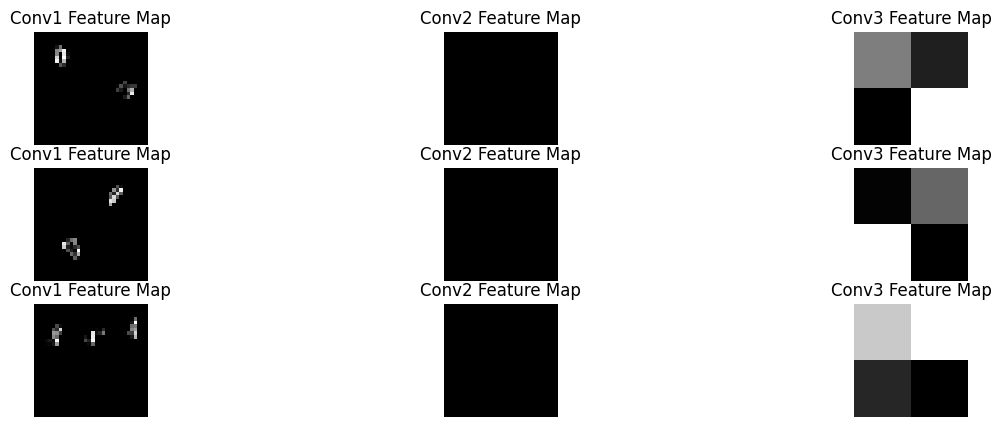

In [45]:
model_single_regression.visulize_feature_maps(train_loader_regression, device=device)

In [46]:
def load_mnist_data_multilabel(path):
    splits = ['train', 'val', 'test']
    data = {'train': [], 'val': [], 'test': []}
    labels = {'train': [], 'val': [], 'test': []}
    for split in splits:
        split_path = os.path.join(path, split)
        for label in os.listdir(split_path):
            label_path = os.path.join(split_path, label)
            if (len(label) == 1 and int(label) == 0):
                cur_label = []
            else:
                cur_label = [int(i) for i in label]
            if os.path.isdir(label_path):
                for image_name in os.listdir(label_path):
                    image_path = os.path.join(label_path, image_name)
                    try:
                        image = Image.open(image_path).convert('L')
                        image_array = np.array(image)
                        data[split].append(image_array)
                        labels[split].append(cur_label)
                    except Exception as e:
                        print(f"Error loading image {image_name}: {e}")
    
    return data['train'], labels['train'], data['val'], labels['val'], data['test'], labels['test']

In [47]:
def get_one_hot(y):
    one_hot = np.zeros(33)
    if len(y) == 0:
        y.append(10)
        y.append(10)
        y.append(10)
    elif len(y) == 1:
        y.append(10)
        y.append(10)
    elif len(y) == 2:
        y.append(10)
    for i in range(len(y)):
        one_hot[y[i]+10*i+i] = 1
    return one_hot

In [48]:
class MultiMNISTDataset_mulitlabel(Dataset):
    def __init__(self, images, labels, task='multilabel_classification', transform=None):
        self.images = images
        self.labels = labels
        self.task = task
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = torch.tensor(image, dtype=torch.float32) / 255.0
        image = image.unsqueeze(0)

        if self.transform:
            image = self.transform(image)

        if self.task == 'multilabel_classification':
            label = torch.tensor(label, dtype=torch.float32).to(device)
        else:
            label = torch.tensor(label, dtype=torch.float32).to(device).unsqueeze(0)
        return image, label


In [49]:
class CNN_Multilabel(nn.Module):
    def __init__(self, task='multilabel_classification', num_classes=33):
        super(CNN_Multilabel, self).__init__()
        
        self.task = task
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
        self.fc1 = None
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def _initialize_fc(self, input_shape, device):
        dummy_input = torch.zeros(1, *input_shape).to(device)
        with torch.no_grad():
            output = self._forward_conv(dummy_input)
        flattened_size = output.view(-1).shape[0]
        self.fc1 = nn.Linear(flattened_size, 128).to(device)

    def _forward_conv(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        return x

    def forward(self, x):
        if self.fc1 is None:
            self._initialize_fc(x.shape[1:], x.device)

        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def get_accuracy(self, y_pred, y_true):
        if self.task == 'multilabel_classification':
            y_pred_labels = self.convert_to_labels(y_pred)
            y_true_labels = self.convert_to_labels(y_true)
            accuracy = 0
            for i in range(len(y_pred_labels)):
                flag = 1
                if len(y_pred_labels[i]) == len(y_true_labels[i]):
                    for j in range(len(y_pred_labels[i])):
                        if y_pred_labels[i][j] != y_true_labels[i][j]:
                            flag = 0
                            break
                else:
                    flag = 0
                accuracy += flag
            return accuracy/len(y_pred_labels)
        else:
            return F.mse_loss(y_pred, y_true)


    def loss(self, y_pred, y_true):
        if self.task == 'multilabel_classification':
            criterion = nn.CrossEntropyLoss()
            loss = 0
            for i in range(3):
                start = i * 11
                end = (i + 1) * 11
                target_idx = torch.argmax(y_true[:, start:end], dim=1)
                loss += criterion(y_pred[:, start:end], target_idx)
            return loss
        else:
            return F.mse_loss(y_pred, y_true)
            
    def convert_to_labels(self, y_pred):
        labels = []
        batch_size = y_pred.shape[0]
        for i in range(batch_size):
            label = []
            for j in range(3):
                start = j * 11
                end = (j + 1) * 11
                cur_label = torch.argmax(y_pred[i, start:end]).item()
                if cur_label != 10:
                    label.append(cur_label)
                else:
                    break
            labels.append(label)
        return labels
    
    def train_model(self, optimizer, train_loader, val_loader, num_epochs=30, device='cpu'):
        self.to(device)
        for epoch in range(num_epochs):
            self.train()
            train_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}")
            
            for i, (x, y) in train_progress:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                y_pred = self.forward(x)
                loss = self.loss(y_pred, y)
                loss.backward()
                optimizer.step()
                train_progress.set_postfix({"Loss": f"{loss.item():.4f}"})
            
            self.eval()
            total_accuracy = 0
            total_loss = 0
            with torch.no_grad():
                for x, y in val_loader:
                    x, y = x.to(device), y.to(device)
                    y_pred = self.forward(x)
                    total_loss += self.loss(y_pred, y).item()
                    total_accuracy += self.get_accuracy(y_pred, y)

                avg_loss = total_loss / len(val_loader)
                accuracy = total_accuracy / len(val_loader)
                print(f"Epoch {epoch + 1}, Validation Accuracy: {accuracy*100:.2f}%, Validation Loss: {avg_loss:.6f}")

In [50]:
train_data_multilabel, train_labels_multilabel, val_data_multilabel, val_labels_multilabel, test_data_multilabel, test_labels_multilabel = load_mnist_data_multilabel(data_path)

In [51]:
train_labels_multilabel_one_hot = [get_one_hot(y) for y in train_labels_multilabel]
val_labels_multilabel_one_hot = [get_one_hot(y) for y in val_labels_multilabel]
test_labels_multilabel_one_hot = [get_one_hot(y) for y in test_labels_multilabel]

In [52]:

train_data_multilabel = MultiMNISTDataset_mulitlabel(train_data_multilabel, train_labels_multilabel_one_hot)
val_data_multilabel = MultiMNISTDataset_mulitlabel(val_data_multilabel, val_labels_multilabel_one_hot)
test_data_multilabel = MultiMNISTDataset_mulitlabel(test_data_multilabel, test_labels_multilabel_one_hot)

train_loader_multilabel = DataLoader(train_data_multilabel, batch_size=32, shuffle=True)
val_loader_multilabel = DataLoader(val_data_multilabel, batch_size=32, shuffle=False)
test_loader_multilabel = DataLoader(test_data_multilabel, batch_size=32, shuffle=False)

In [53]:
model_multilabel_classfication = CNN_Multilabel(task='multilabel_classification', num_classes=33).to(device)

optimizer = torch.optim.Adam(model_multilabel_classfication.parameters(), lr=0.001)
model_multilabel_classfication.train_model(optimizer, train_loader_multilabel, val_loader_multilabel, num_epochs=50, device=device)

Epoch 1/50: 100%|██████████| 394/394 [00:05<00:00, 66.77it/s, Loss=4.8760]


Epoch 1, Validation Accuracy: 4.52%, Validation Loss: 5.099566


Epoch 2/50: 100%|██████████| 394/394 [00:05<00:00, 65.76it/s, Loss=4.5735]


Epoch 2, Validation Accuracy: 4.09%, Validation Loss: 5.255568


Epoch 3/50: 100%|██████████| 394/394 [00:05<00:00, 72.61it/s, Loss=4.3825]


Epoch 3, Validation Accuracy: 4.65%, Validation Loss: 5.170583


Epoch 4/50: 100%|██████████| 394/394 [00:05<00:00, 72.59it/s, Loss=4.2913]


Epoch 4, Validation Accuracy: 5.22%, Validation Loss: 5.029811


Epoch 5/50: 100%|██████████| 394/394 [00:05<00:00, 70.77it/s, Loss=4.2703]


Epoch 5, Validation Accuracy: 6.15%, Validation Loss: 4.638579


Epoch 6/50: 100%|██████████| 394/394 [00:05<00:00, 70.77it/s, Loss=3.4877]


Epoch 6, Validation Accuracy: 6.38%, Validation Loss: 4.645889


Epoch 7/50: 100%|██████████| 394/394 [00:05<00:00, 69.40it/s, Loss=3.7618]


Epoch 7, Validation Accuracy: 5.10%, Validation Loss: 4.768686


Epoch 8/50: 100%|██████████| 394/394 [00:05<00:00, 71.56it/s, Loss=3.5855]


Epoch 8, Validation Accuracy: 5.95%, Validation Loss: 4.820654


Epoch 9/50: 100%|██████████| 394/394 [00:06<00:00, 65.06it/s, Loss=3.3075]


Epoch 9, Validation Accuracy: 4.39%, Validation Loss: 4.950604


Epoch 10/50: 100%|██████████| 394/394 [00:06<00:00, 59.11it/s, Loss=3.4266]


Epoch 10, Validation Accuracy: 4.79%, Validation Loss: 4.893893


Epoch 11/50: 100%|██████████| 394/394 [00:06<00:00, 63.90it/s, Loss=2.5415]


Epoch 11, Validation Accuracy: 4.99%, Validation Loss: 5.079710


Epoch 12/50: 100%|██████████| 394/394 [00:06<00:00, 63.30it/s, Loss=2.4900]


Epoch 12, Validation Accuracy: 5.43%, Validation Loss: 4.786793


Epoch 13/50: 100%|██████████| 394/394 [00:06<00:00, 65.33it/s, Loss=3.3584]


Epoch 13, Validation Accuracy: 5.63%, Validation Loss: 5.223122


Epoch 14/50: 100%|██████████| 394/394 [00:06<00:00, 64.40it/s, Loss=2.3973]


Epoch 14, Validation Accuracy: 6.86%, Validation Loss: 4.957839


Epoch 15/50: 100%|██████████| 394/394 [00:06<00:00, 61.84it/s, Loss=2.0037]


Epoch 15, Validation Accuracy: 7.31%, Validation Loss: 5.201252


Epoch 16/50: 100%|██████████| 394/394 [00:06<00:00, 64.25it/s, Loss=1.8650]


Epoch 16, Validation Accuracy: 7.05%, Validation Loss: 4.754552


Epoch 17/50: 100%|██████████| 394/394 [00:06<00:00, 64.07it/s, Loss=2.3768]


Epoch 17, Validation Accuracy: 10.07%, Validation Loss: 4.683681


Epoch 18/50: 100%|██████████| 394/394 [00:06<00:00, 60.83it/s, Loss=2.0646]


Epoch 18, Validation Accuracy: 10.18%, Validation Loss: 4.571017


Epoch 19/50: 100%|██████████| 394/394 [00:06<00:00, 62.48it/s, Loss=2.3770]


Epoch 19, Validation Accuracy: 12.79%, Validation Loss: 4.275096


Epoch 20/50: 100%|██████████| 394/394 [00:06<00:00, 65.59it/s, Loss=1.8936]


Epoch 20, Validation Accuracy: 14.57%, Validation Loss: 4.422835


Epoch 21/50: 100%|██████████| 394/394 [00:05<00:00, 66.26it/s, Loss=1.4528]


Epoch 21, Validation Accuracy: 13.71%, Validation Loss: 4.631272


Epoch 22/50: 100%|██████████| 394/394 [00:05<00:00, 65.75it/s, Loss=1.5084]


Epoch 22, Validation Accuracy: 16.31%, Validation Loss: 4.121992


Epoch 23/50: 100%|██████████| 394/394 [00:06<00:00, 64.41it/s, Loss=1.6584]


Epoch 23, Validation Accuracy: 14.87%, Validation Loss: 4.404699


Epoch 24/50: 100%|██████████| 394/394 [00:06<00:00, 64.58it/s, Loss=1.5126]


Epoch 24, Validation Accuracy: 17.62%, Validation Loss: 4.553759


Epoch 25/50: 100%|██████████| 394/394 [00:06<00:00, 65.43it/s, Loss=1.7673]


Epoch 25, Validation Accuracy: 17.21%, Validation Loss: 4.516986


Epoch 26/50: 100%|██████████| 394/394 [00:06<00:00, 65.06it/s, Loss=1.8116]


Epoch 26, Validation Accuracy: 16.67%, Validation Loss: 4.670533


Epoch 27/50: 100%|██████████| 394/394 [00:05<00:00, 66.10it/s, Loss=1.7010]


Epoch 27, Validation Accuracy: 19.37%, Validation Loss: 4.649272


Epoch 28/50: 100%|██████████| 394/394 [00:06<00:00, 65.40it/s, Loss=1.3608]


Epoch 28, Validation Accuracy: 20.38%, Validation Loss: 4.233184


Epoch 29/50: 100%|██████████| 394/394 [00:05<00:00, 67.16it/s, Loss=1.2101]


Epoch 29, Validation Accuracy: 21.56%, Validation Loss: 4.560287


Epoch 30/50: 100%|██████████| 394/394 [00:06<00:00, 63.43it/s, Loss=1.7948]


Epoch 30, Validation Accuracy: 18.51%, Validation Loss: 4.608364


Epoch 31/50: 100%|██████████| 394/394 [00:06<00:00, 64.41it/s, Loss=1.3747]


Epoch 31, Validation Accuracy: 21.25%, Validation Loss: 4.710623


Epoch 32/50: 100%|██████████| 394/394 [00:06<00:00, 64.24it/s, Loss=0.7126]


Epoch 32, Validation Accuracy: 21.56%, Validation Loss: 4.735734


Epoch 33/50: 100%|██████████| 394/394 [00:06<00:00, 64.25it/s, Loss=1.0431]


Epoch 33, Validation Accuracy: 22.11%, Validation Loss: 4.873747


Epoch 34/50: 100%|██████████| 394/394 [00:05<00:00, 67.16it/s, Loss=0.6413]


Epoch 34, Validation Accuracy: 22.17%, Validation Loss: 5.059330


Epoch 35/50: 100%|██████████| 394/394 [00:05<00:00, 70.27it/s, Loss=1.4211]


Epoch 35, Validation Accuracy: 22.11%, Validation Loss: 4.776842


Epoch 36/50: 100%|██████████| 394/394 [00:05<00:00, 72.58it/s, Loss=0.9504]


Epoch 36, Validation Accuracy: 22.23%, Validation Loss: 5.135653


Epoch 37/50: 100%|██████████| 394/394 [00:05<00:00, 69.58it/s, Loss=0.6110]


Epoch 37, Validation Accuracy: 23.37%, Validation Loss: 5.157188


Epoch 38/50: 100%|██████████| 394/394 [00:05<00:00, 71.14it/s, Loss=1.0171]


Epoch 38, Validation Accuracy: 22.12%, Validation Loss: 5.493681


Epoch 39/50: 100%|██████████| 394/394 [00:05<00:00, 70.96it/s, Loss=0.6135]


Epoch 39, Validation Accuracy: 24.28%, Validation Loss: 4.983200


Epoch 40/50: 100%|██████████| 394/394 [00:05<00:00, 71.80it/s, Loss=0.7747]


Epoch 40, Validation Accuracy: 24.25%, Validation Loss: 5.101889


Epoch 41/50: 100%|██████████| 394/394 [00:05<00:00, 71.76it/s, Loss=0.6670]


Epoch 41, Validation Accuracy: 23.14%, Validation Loss: 5.643443


Epoch 42/50: 100%|██████████| 394/394 [00:05<00:00, 70.96it/s, Loss=0.4368]


Epoch 42, Validation Accuracy: 25.02%, Validation Loss: 5.365471


Epoch 43/50: 100%|██████████| 394/394 [00:05<00:00, 70.96it/s, Loss=0.4169]


Epoch 43, Validation Accuracy: 24.70%, Validation Loss: 5.532203


Epoch 44/50: 100%|██████████| 394/394 [00:05<00:00, 70.89it/s, Loss=0.5681]


Epoch 44, Validation Accuracy: 25.57%, Validation Loss: 5.285016


Epoch 45/50: 100%|██████████| 394/394 [00:05<00:00, 70.86it/s, Loss=0.5580]


Epoch 45, Validation Accuracy: 24.41%, Validation Loss: 6.053100


Epoch 46/50: 100%|██████████| 394/394 [00:05<00:00, 71.56it/s, Loss=0.3827]


Epoch 46, Validation Accuracy: 24.58%, Validation Loss: 6.308886


Epoch 47/50: 100%|██████████| 394/394 [00:05<00:00, 70.97it/s, Loss=0.2818]


Epoch 47, Validation Accuracy: 23.36%, Validation Loss: 6.568561


Epoch 48/50: 100%|██████████| 394/394 [00:05<00:00, 71.17it/s, Loss=0.6079]


Epoch 48, Validation Accuracy: 24.41%, Validation Loss: 6.322136


Epoch 49/50: 100%|██████████| 394/394 [00:05<00:00, 70.00it/s, Loss=0.4568]


Epoch 49, Validation Accuracy: 25.40%, Validation Loss: 6.472981


Epoch 50/50: 100%|██████████| 394/394 [00:05<00:00, 70.76it/s, Loss=0.4787]


Epoch 50, Validation Accuracy: 25.86%, Validation Loss: 5.995592
